# mAD Gene Expression Analysis

In [1]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects

from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statannot import add_stat_annotation

# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

In [2]:
# Colormap related
import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## Input

In [3]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [4]:
# # add batch information 
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'batch'] = 'batch_1'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'batch'] = 'batch_1'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'batch'] = 'batch_2'
# adata.obs.loc[adata.obs['sample'] == 'AD_mouse9981', 'batch'] = 'batch_2'

# add time information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'time'] = '13_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'time'] = '13_months'

# add group information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'group'] = 'control'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'group'] = 'control'

# change dtype
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9781', 'AD_mouse9721', 'AD_mouse9930', 'AD_mouse9919'])

# adata.obs['batch'] = adata.obs['batch'].astype('category')
# adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

adata.obs['group'] = adata.obs['group'].astype('category')

In [5]:
adata

AnnData object with n_obs × n_vars = 40952 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'time', 'group'

In [6]:
adata.obs['sample'].value_counts()

AD_mouse9781    11328
AD_mouse9919    10404
AD_mouse9930     9829
AD_mouse9721     9391
Name: sample, dtype: int64

## Preprocessing

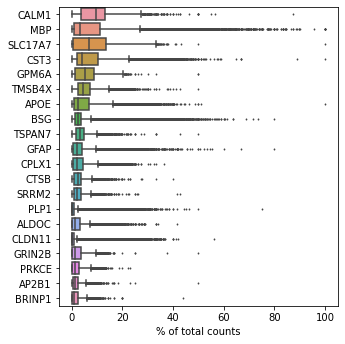

In [6]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
adata.var['max_counts'] = adata.X.max(axis=0)

<AxesSubplot:xlabel='max_counts'>

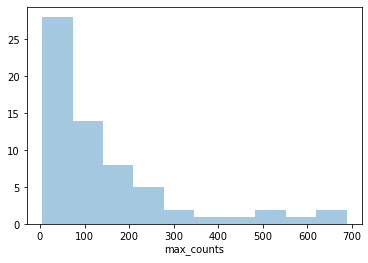

In [70]:
sns.distplot(adata.var['max_counts'], kde=False, )

In [8]:
# Per-cell Stats Plot

# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'log1p_total_counts'],
#              jitter=0.4, multi_panel=True)

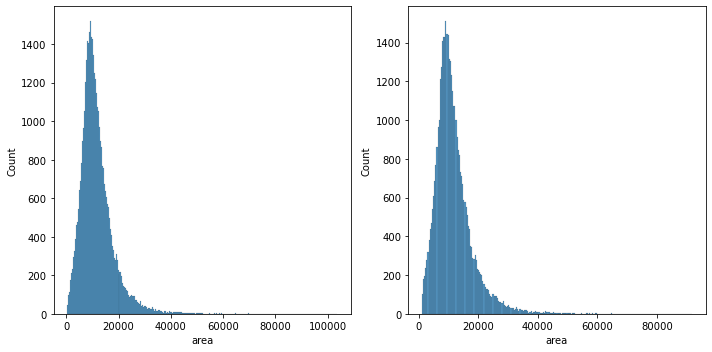

Number of cell left: 40824


In [9]:
# Filter cell by area 
adata = su.filter_cells_by_area(adata, min_area=1000, max_area=100000, save=True)

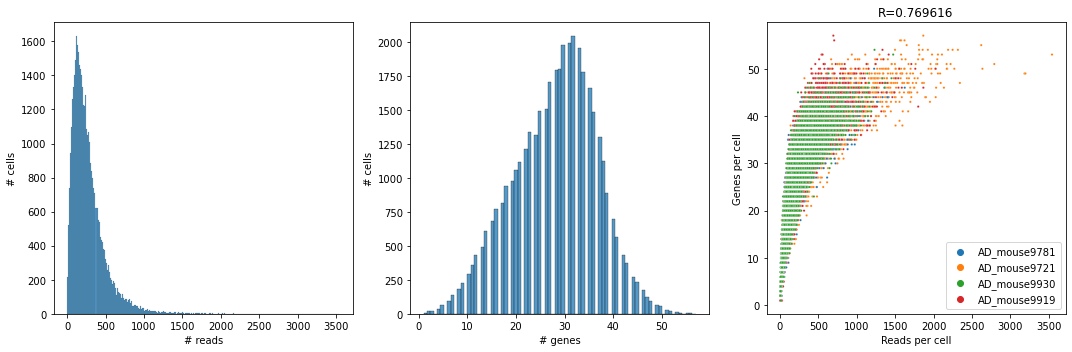

In [10]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, save=True)

In [11]:
# Get quantiles of reads

su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     73.0
0.25    129.0
0.50    222.0
0.75    355.0
0.90    532.0
Name: total_counts, dtype: float64


In [12]:
# Get a copy of meta data
meta = adata.obs.copy()

# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# Filter gene by max counts 
adata = adata[:, adata.var['max_counts'] > 2]

sc.pp.filter_cells(adata, min_counts=73)
sc.pp.filter_cells(adata, max_counts=1500)

adata.layers['raw'] = adata.X
adata.X.shape

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(36625, 64)

In [13]:
adata.write_h5ad('./output/2021-03-23-mAD-64-genes-raw.h5ad')

In [14]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [15]:
# Identify most variable genes
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
# sc.pl.highly_variable_genes(adata)

# print(f"Number of top variable genes: {}")

In [16]:
# # Regress out unwanted variance 
# sc.pp.regress_out(adata, ['total_counts'])

In [17]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

In [18]:
# # Batch correction
# sc.pp.combat(adata)
# adata.layers['corrected'] = adata.X

In [19]:
adata.shape

(36625, 64)

## Clustering

In [36]:
adata = sc.read_h5ad('output/2021-04-08-starmap-mAD-64-genes-scaled.h5ad')
adata

AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'batch_colors', 'cell_type_label', 'cell_type_order', 'group_colors', 'label_hex_dict', 'label_rgb_dict', 'neighbors', 'pca', 'predicted_top_level_colors', 'sample_colors', 'sub_hex_dict', 'sub_rgb_dict', 'time_colors', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PC

In [8]:
# load predictions 
# top-level
prediction_top_level = pd.read_csv('output/integration/predicted_top_level_no_CA2.csv')

adata.obs['predicted_top_level'] = prediction_top_level['predicted.id'].values
adata.obs['predicted_top_level_score'] = prediction_top_level['prediction.score.max'].values

current_top_level_order = [c for c in adata.uns['top_level_order'] if c in adata.obs['predicted_top_level'].unique()]
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].astype('category')
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].cat.reorder_categories(current_top_level_order)

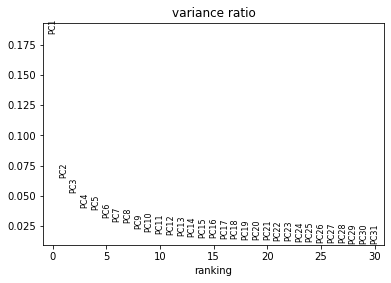

In [37]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

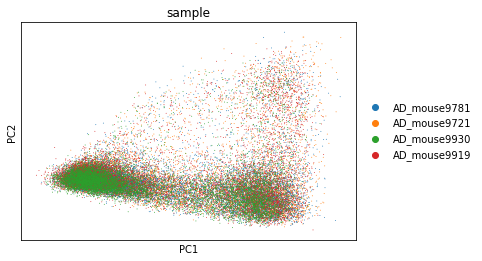

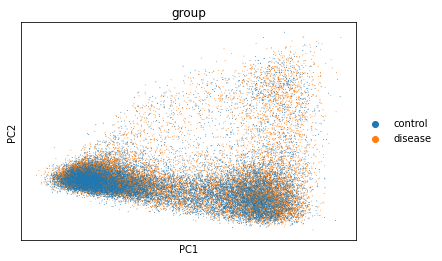

In [38]:
# Plot PCA

sc.pl.pca(adata, color='sample')
sc.pl.pca(adata, color='group')

In [39]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
    
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

CPU times: user 1min 25s, sys: 2.69 s, total: 1min 27s
Wall time: 42.5 s


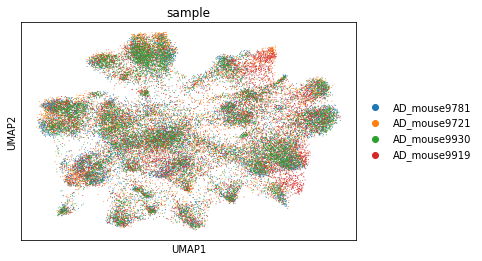

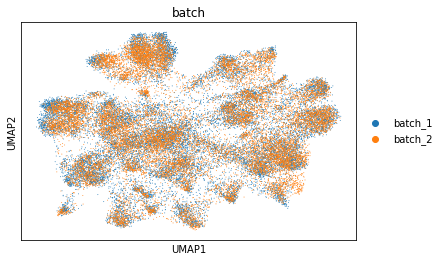

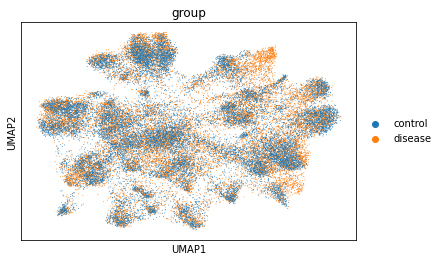

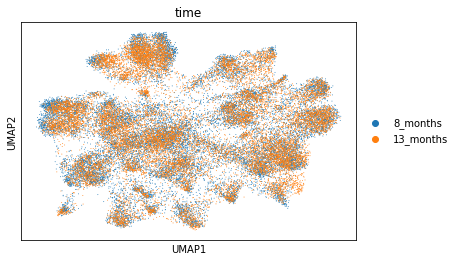

In [40]:
# Plot UMAP
sc.pl.umap(adata, color='sample')
sc.pl.umap(adata, color='batch')
sc.pl.umap(adata, color='group')
sc.pl.umap(adata, color='time')

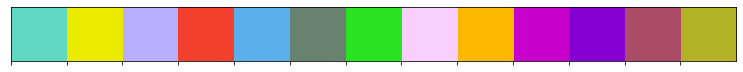

In [29]:
# Get colormap
cluster_pl = [adata.uns['top_hex_dict'][c] for c in adata.obs['predicted_top_level'].cat.categories]
# cluster_pl = sns.color_palette("tab20", adata.obs['leiden'].unique().shape[0])
cluster_cmap = ListedColormap(cluster_pl)
sns.palplot(cluster_pl)

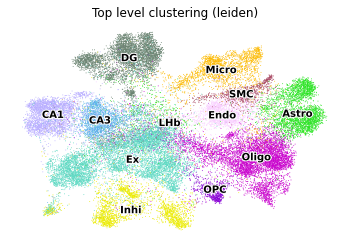

In [14]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='predicted_top_level', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [27]:
(adata.obs['predicted_top_level_score'] >= 0.5).sum()

32862

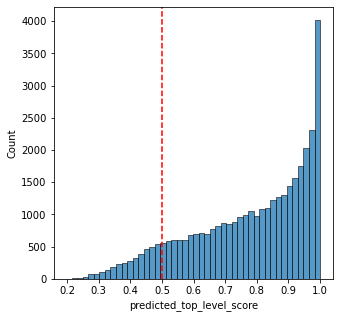

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(adata.obs['predicted_top_level_score'], ax=ax)
plt.axvline(x=0.5, c='r', ls='--')

<AxesSubplot:xlabel='predicted_top_level', ylabel='predicted_top_level_score'>

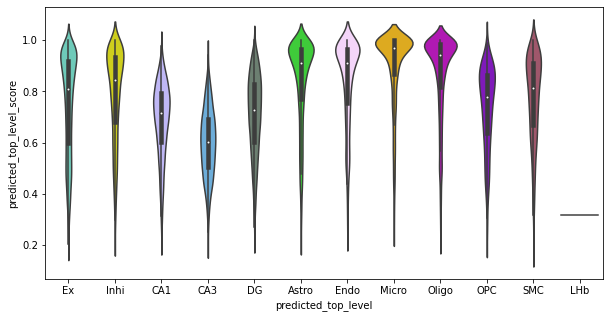

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x=adata.obs['predicted_top_level'], y=adata.obs['paredicted_top_level_score'], palette=cluster_pl, ax=ax)

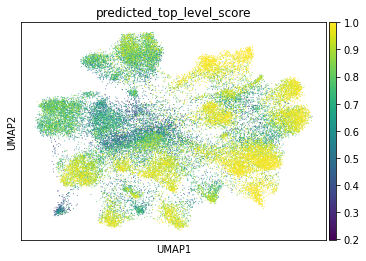

In [87]:
sc.pl.umap(adata, color='predicted_top_level_score')

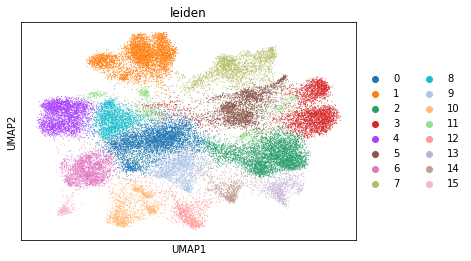

CPU times: user 22.2 s, sys: 1.15 s, total: 23.4 s
Wall time: 23.4 s


In [44]:
%%time
# Run louvain cluster
cluster_resolution = .7
sc.tl.leiden(adata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(adata, color='leiden')

# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}""")

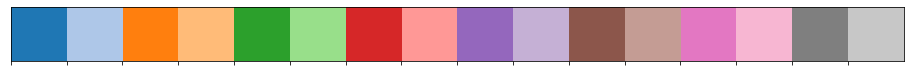

In [45]:
# Get colormap
cluster_pl = sns.color_palette("tab20", adata.obs['leiden'].unique().shape[0])
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

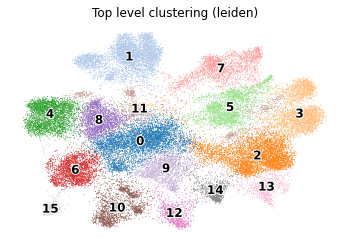

In [46]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

In [47]:
# Get markers for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)

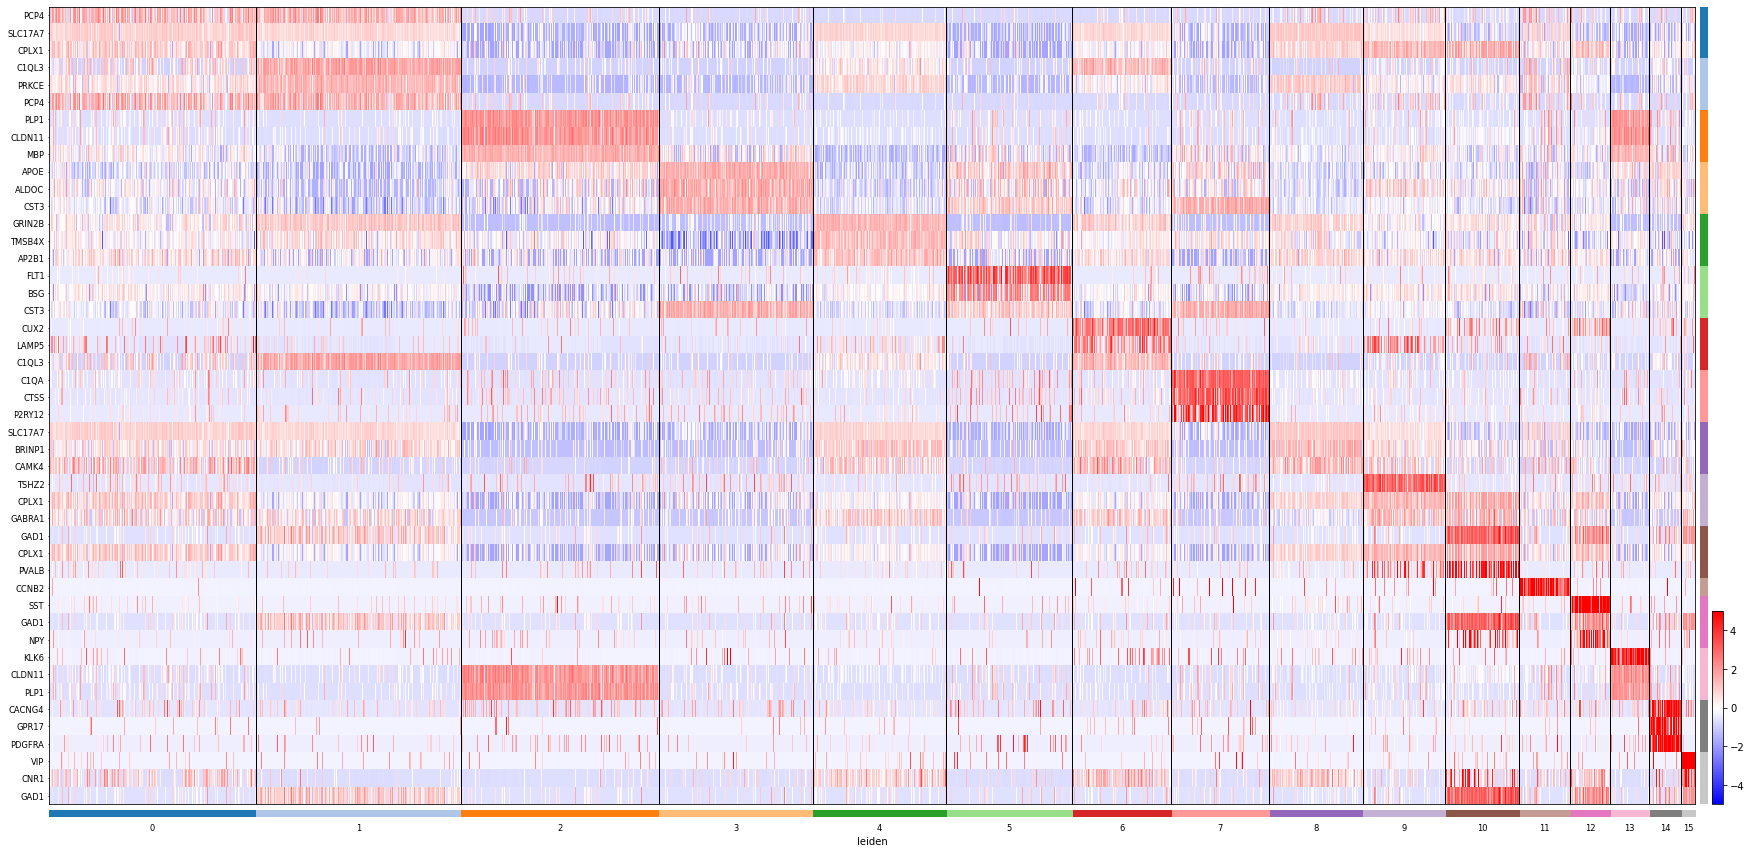

In [48]:
# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=True)

In [49]:
# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# # print(markers)
# plt.figure(figsize=(30,15))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', cmap=cluster_cmap, show_axis=True, font_size=10)

0 ['PCP4', 'SLC17A7', 'CPLX1', 'CAMK4', 'CALM1']
1 ['C1QL3', 'PRKCE', 'PCP4', 'GRIN2B', 'GAD1']
2 ['PLP1', 'CLDN11', 'MBP', 'APOE', 'GFAP']
3 ['APOE', 'ALDOC', 'CST3', 'HTRA1', 'C4B']
4 ['GRIN2B', 'TMSB4X', 'AP2B1', 'GPM6A', 'BRINP1']
5 ['FLT1', 'BSG', 'CST3', 'APOE', 'VTN']
6 ['CUX2', 'LAMP5', 'C1QL3', 'GPM6A', 'CALM1']
7 ['C1QA', 'CTSS', 'P2RY12', 'TGFBR1', 'CST3']
8 ['SLC17A7', 'BRINP1', 'CAMK4', 'PRKCE', 'CNR1']
9 ['TSHZ2', 'CPLX1', 'GABRA1', 'MYO5A', 'LAMP5']
10 ['GAD1', 'CPLX1', 'PVALB', 'GABRA1', 'NPY']
11 ['CCNB2', 'C4B', 'PCP4', 'GFAP', 'PCDH9']
12 ['SST', 'GAD1', 'NPY', 'CPLX1', 'CUX2']
13 ['KLK6', 'CLDN11', 'PLP1', 'MBP', 'C4B']
14 ['CACNG4', 'GPR17', 'PDGFRA', 'CD9', 'APOE']
15 ['VIP', 'CNR1', 'GAD1', 'GABRA1', 'RPH3A']


### assign top-level label

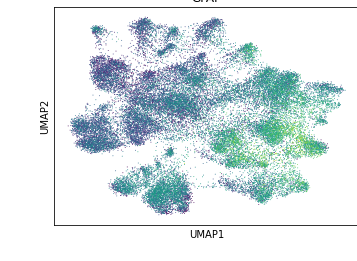

In [45]:
sc.pl.umap(adata, color='GFAP', save=True)

In [50]:
# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['PCP4', 'SLC17A7', 'CPLX1', 'CAMK4', 'CALM1']
1 ['C1QL3', 'PRKCE', 'PCP4', 'GRIN2B', 'GAD1']
2 ['PLP1', 'CLDN11', 'MBP', 'APOE', 'GFAP']
3 ['APOE', 'ALDOC', 'CST3', 'HTRA1', 'C4B']
4 ['GRIN2B', 'TMSB4X', 'AP2B1', 'GPM6A', 'BRINP1']
5 ['FLT1', 'BSG', 'CST3', 'APOE', 'VTN']
6 ['CUX2', 'LAMP5', 'C1QL3', 'GPM6A', 'CALM1']
7 ['C1QA', 'CTSS', 'P2RY12', 'TGFBR1', 'CST3']
8 ['SLC17A7', 'BRINP1', 'CAMK4', 'PRKCE', 'CNR1']
9 ['TSHZ2', 'CPLX1', 'GABRA1', 'MYO5A', 'LAMP5']
10 ['GAD1', 'CPLX1', 'PVALB', 'GABRA1', 'NPY']
11 ['CCNB2', 'C4B', 'PCP4', 'GFAP', 'PCDH9']
12 ['SST', 'GAD1', 'NPY', 'CPLX1', 'CUX2']
13 ['KLK6', 'CLDN11', 'PLP1', 'MBP', 'C4B']
14 ['CACNG4', 'GPR17', 'PDGFRA', 'CD9', 'APOE']
15 ['VIP', 'CNR1', 'GAD1', 'GABRA1', 'RPH3A']


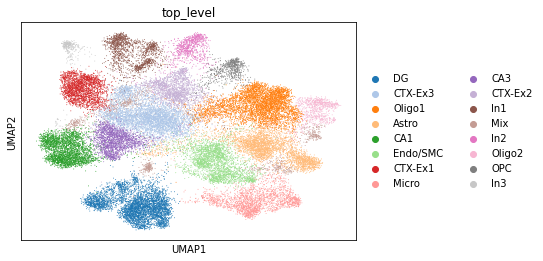

In [105]:
sc.pl.umap(adata, color='top_level')

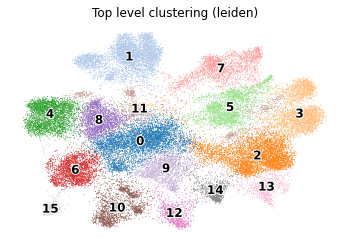

In [51]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [52]:
# Change cluster label to cell type label
transfer_dict = {}
top_level_list = ['Ex', 'DG', 'Oligo', 'Astro', 'CA1', 
                  'Endo-SMC', 'Ex', 'Micro', 'CA3', 'Ex', 
                  'Inhi', 'Mix', 'Inhi', 'Oligo', 'OPC', 'Inhi']

for i in sorted(adata.obs['leiden'].unique()):
    transfer_dict[i] = top_level_list[int(i)]

In [53]:
# Assign cell type to sdata
adata.obs['top_level'] = adata.obs['leiden'].values
adata.obs = adata.obs.replace({'top_level': transfer_dict})

# Sort category
top_level_order = ['Ex', 'Inhi', 'CA1', 'CA3', 'DG', 'Astro', 'Endo-SMC', 'Micro', 'Oligo', 'OPC', 'Mix']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(top_level_order, inplace=True)

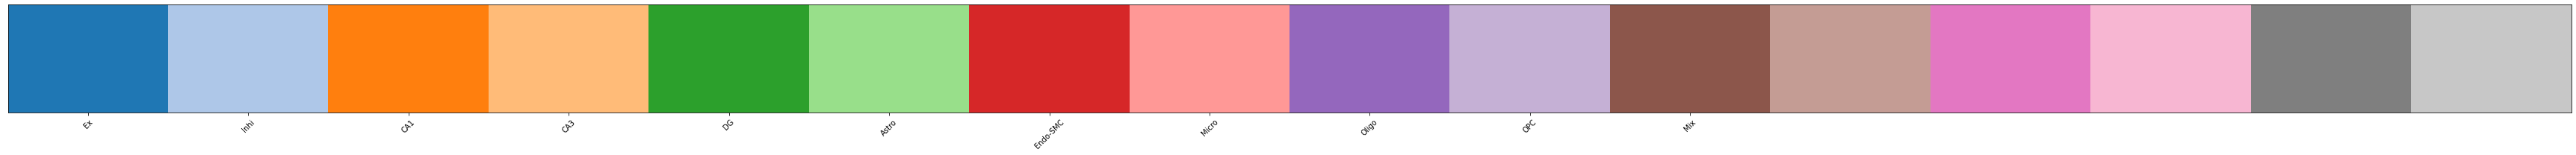

In [54]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

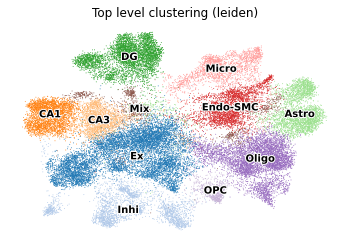

In [55]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

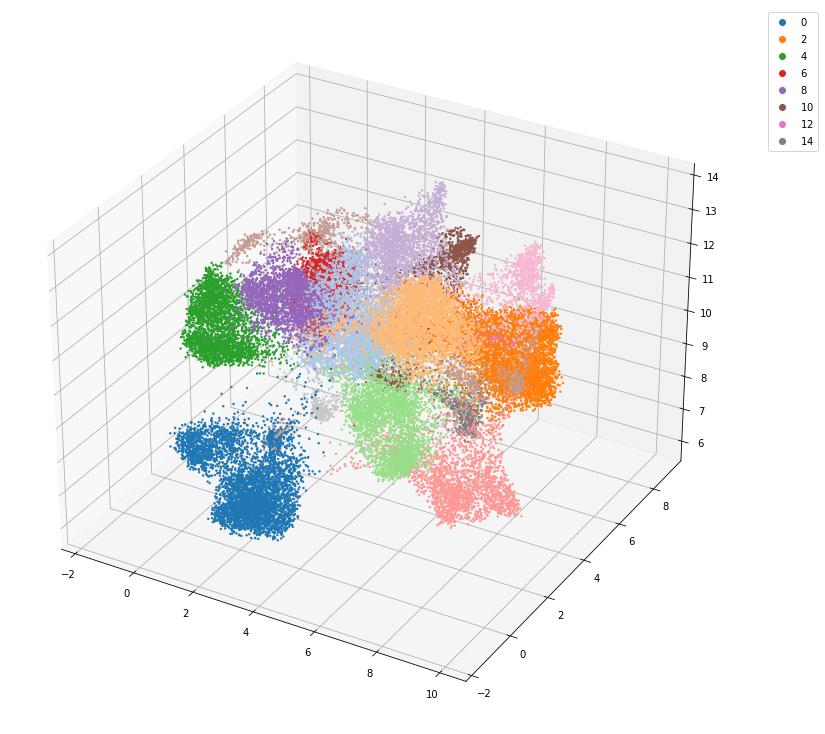

In [97]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# plot
sc = ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], adata.obsm['X_umap'][:,2], s=2, c=adata.obs['leiden'].astype(int), marker='o', cmap=cluster_cmap, alpha=1)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

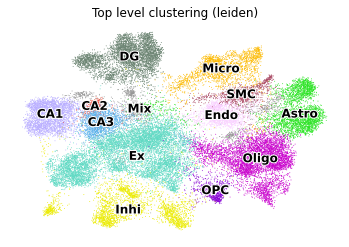

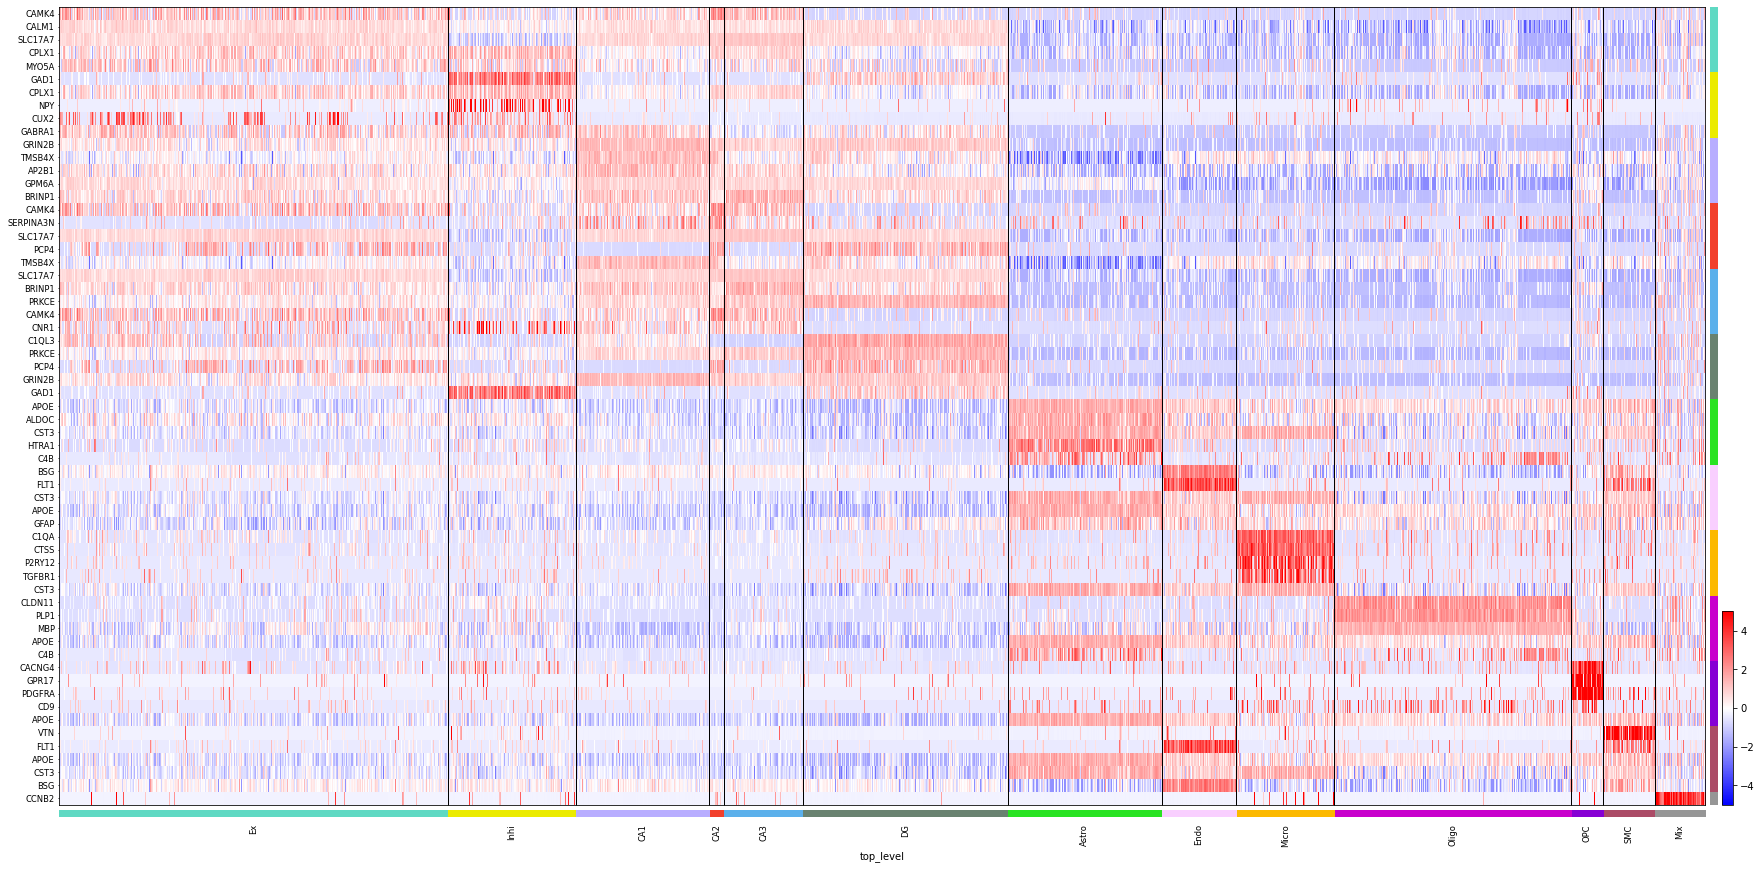

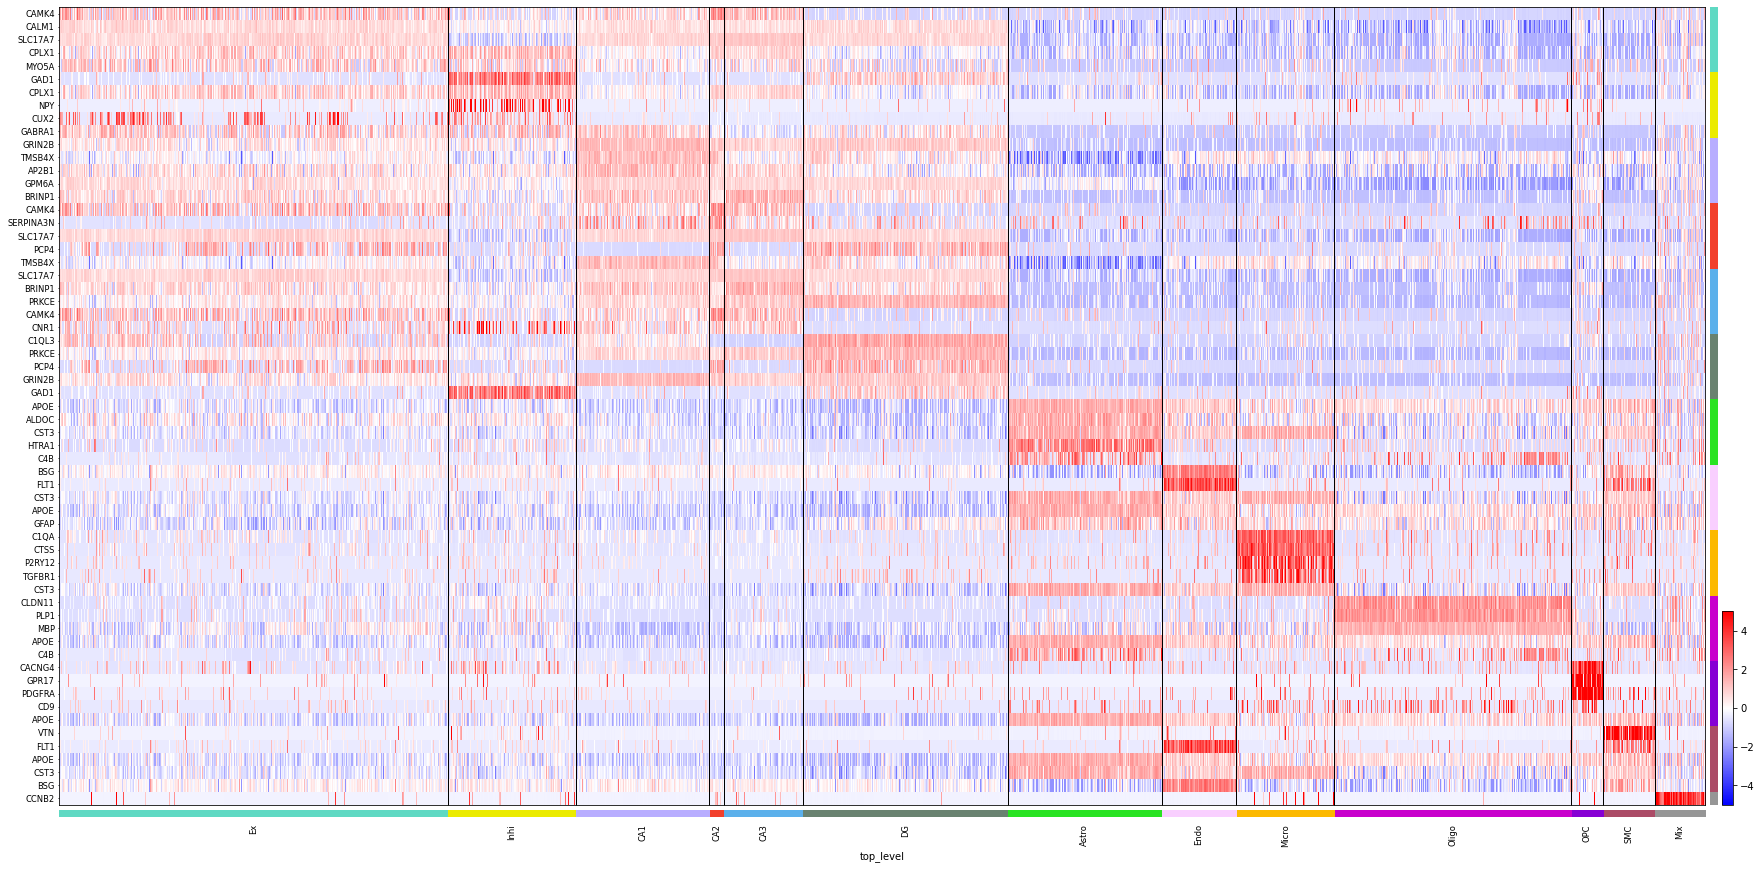

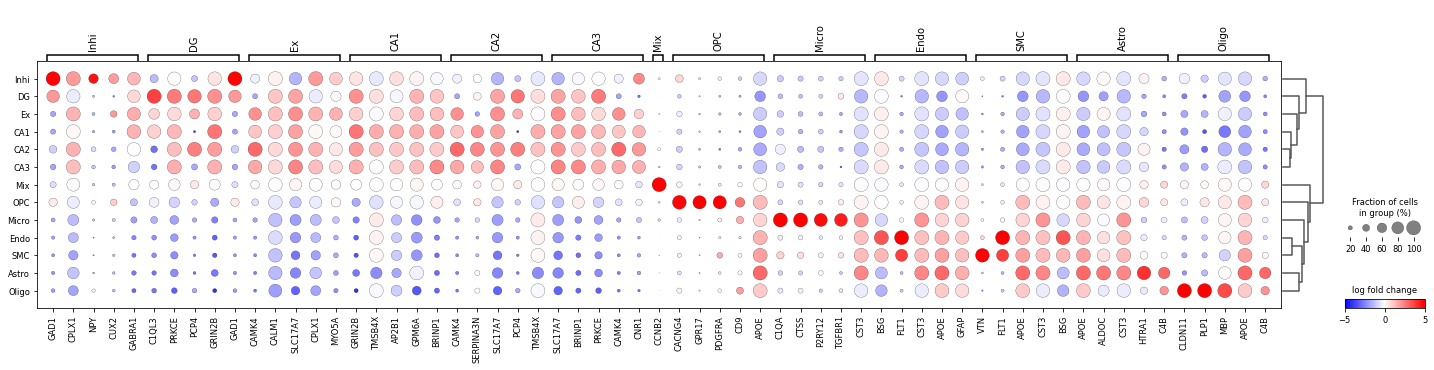

['CAMK4', 'CALM1', 'SLC17A7', 'CPLX1', 'MYO5A']
['GAD1', 'CPLX1', 'NPY', 'CUX2', 'GABRA1']
['GRIN2B', 'TMSB4X', 'AP2B1', 'GPM6A', 'BRINP1']
['CAMK4', 'SERPINA3N', 'SLC17A7', 'PCP4', 'TMSB4X']
['SLC17A7', 'BRINP1', 'PRKCE', 'CAMK4', 'CNR1']
['C1QL3', 'PRKCE', 'PCP4', 'GRIN2B', 'GAD1']
['APOE', 'ALDOC', 'CST3', 'HTRA1', 'C4B']
['BSG', 'FLT1', 'CST3', 'APOE', 'GFAP']
['C1QA', 'CTSS', 'P2RY12', 'TGFBR1', 'CST3']
['CLDN11', 'PLP1', 'MBP', 'APOE', 'C4B']
['CACNG4', 'GPR17', 'PDGFRA', 'CD9', 'APOE']
['VTN', 'FLT1', 'APOE', 'CST3', 'BSG']
['CCNB2', 'C4B', 'PCP4', 'GFAP', 'PCDH9']


In [112]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(adata, groupby='top_level', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=1, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

In [59]:
# sc.pl.correlation_matrix(adata, 'top_level', figsize=(10,7), show_correlation_numbers=True)

## Morphology 

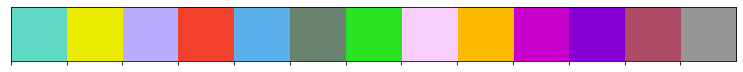

In [109]:
# Get colormap
cluster_pl = [adata.uns['top_hex_dict_64'][c] for c in adata.obs['top_level'].cat.categories]
cluster_cmap = ListedColormap(cluster_pl)
sns.palplot(cluster_pl)

In [64]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)
#     current_tau = gaussian(current_tau.astype(np.float), 2) > 50

    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau
#     adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(current_img)
    
#     current_index = adata.obs['sample'] == sample
#     adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
#     adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'leiden'].astype(int).values

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [96]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'leiden'].astype(int).values
    
    sdata = adata[adata.obs['leiden'] == '9', ]
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=False,
                                        figscale=3, width=10, height=10, save=True, show=False)
    

AD_mouse9721
Geting ConvexHull...
Used 9391 / 9391
AD_mouse9781
Geting ConvexHull...
Used 11328 / 11328
AD_mouse9919
Geting ConvexHull...
Used 10404 / 10404
AD_mouse9930
Geting ConvexHull...
Used 9829 / 9829


In [110]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    

AD_mouse9721
Geting ConvexHull...
Used 9391 / 9391
AD_mouse9781
Geting ConvexHull...
Used 11328 / 11328
AD_mouse9919
Geting ConvexHull...
Used 10404 / 10404
AD_mouse9930
Geting ConvexHull...
Used 9829 / 9829


In [111]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [ ]:
for i, sample in enumerate(sorted(adata.obs['sample'].unique())):
    if i == 0:
        su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                            figscale=10, width=10, height=10, save=False, show=True)

In [62]:
# backup
adata.write_h5ad('./output/2020-11-11-mAD.h5ad')

In [113]:
gene_annotation = pd.read_csv('./genes_annotation.csv')
gene_annotation

Gene            Annotation            top_level   cell_type
0   SLC17A7  general but low expr                   Ex         NaN
1      CUX2                   NaN                   Ex        L2/3
2     TSHZ2                   NaN                   Ex  L4/5_RSC_A
3     CPLX1                   NaN                   Ex  L4/5_RSC_B
4      PCP4  general but low expr                   Ex          L6
..      ...                   ...                  ...         ...
59    SRRM2                  Down       All excitatory         NaN
60     RHOC                    Up  Tau positive neuron         NaN
61    PRKCE                    Up  Tau positive neuron         NaN
62    AP2B1                    Up  Tau positive neuron         NaN
63   GABRA1                    Up  Tau positive neuron         NaN

[64 rows x 4 columns]

In [114]:
adata.obs['tag'] = adata.obs['time'].astype(str) + '_' + adata.obs['group'].astype(str)
adata.obs['tag'] = adata.obs['tag'].astype('category')
adata.obs['tag'] = adata.obs['tag'].cat.reorder_categories(['8_months_control', '8_months_disease', 
                                                            '13_months_control', '13_months_disease'])

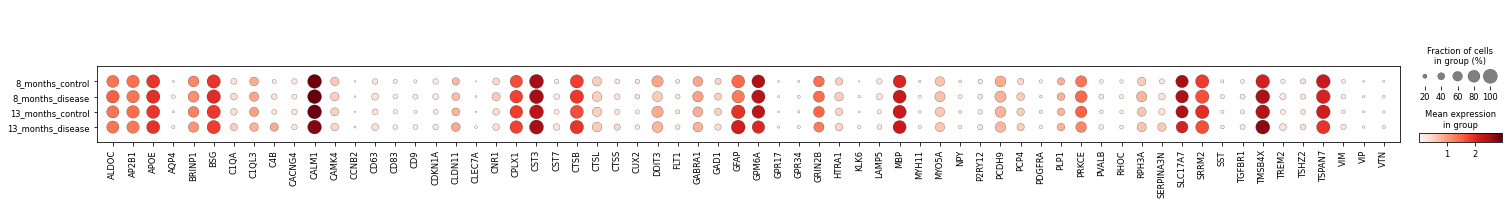

In [115]:
final_genes = adata.var.index.to_list()
sc.pl.dotplot(adata, final_genes, groupby='tag', use_raw=True, swap_axes=False)

In [505]:
adata = sc.read_h5ad('../2020-10-09-mAD-reads-assignment/output/2020-12-27-starmap-mAD-scaled.h5ad')

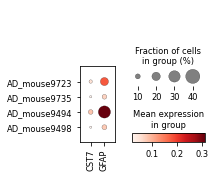

In [524]:
sc.pl.dotplot(adata, ['CST7', 'GFAP'], groupby='sample')

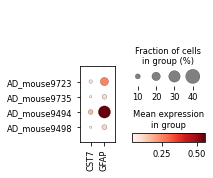

In [504]:
sc.pl.dotplot(adata, ['CST7', 'GFAP'], groupby='sample')

## Sub-level clustering

In [374]:
# Create complete array
complete_cluster_pl = []
complete_cell_type_order = []

<hr>

In [77]:
# Subset
sub_id = 'Endo-SMC'

# sub_obs = adata.obs.loc[adata.obs['predicted_top_level'] == sub_id, :]
# median_score = np.mean(sub_obs['predicted_top_level_score'])

# curr_cells = (adata.obs['predicted_top_level'] == sub_id) & (adata.obs['predicted_top_level_score'] > median_score)
# curr_cells = adata.obs['predicted_top_level'] == sub_id
curr_cells = adata.obs['top_level'] == sub_id

sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 2807 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'batch_colors', 'cell_type_label', 'cell_type_order', 'group_colors', 'label_hex_dict', 'label_rgb_dict', 'neighbors', 'pca', 'sample_colors', 'sub_hex_dict', 'sub_rgb_dict', 'time_colors', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'umap', 'leiden', 'leiden_colors', 'rank_genes_g

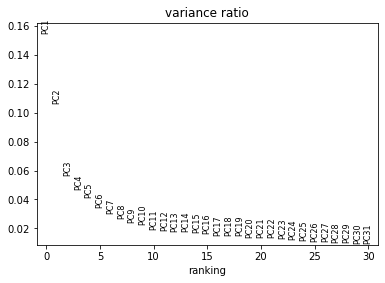

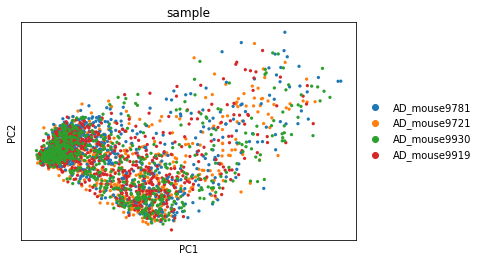

In [78]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='sample')

In [82]:
%%time
# Computing the neighborhood graph
n_neighbors = 10
n_pcs = 20

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

CPU times: user 7.64 s, sys: 552 ms, total: 8.19 s
Wall time: 3.9 s


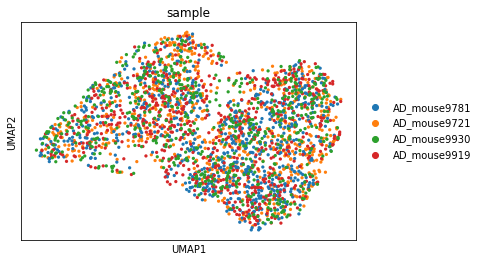

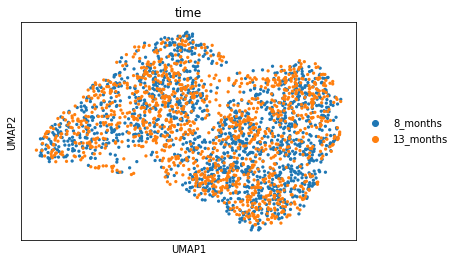

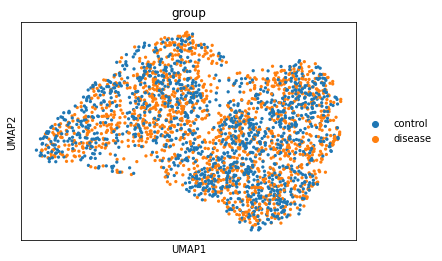

In [83]:
# Plot UMAP
sc.pl.umap(sdata, color='sample')
sc.pl.umap(sdata, color='time')
sc.pl.umap(sdata, color='group')

In [478]:
genes = gene_annotation.loc[gene_annotation['top_level'] == sub_id, 'Gene'].to_list()
genes

['PLP1', 'MBP', 'CLDN11', 'KLK6', 'SERPINA3N', 'C4B', 'CDKN1A']

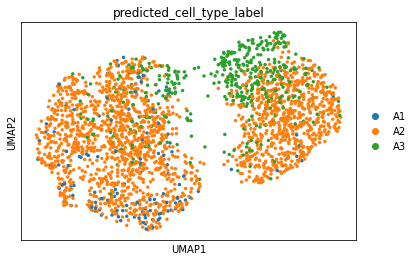

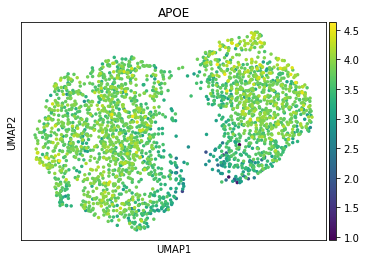

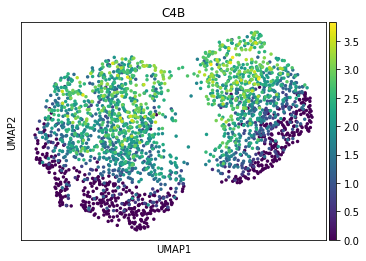

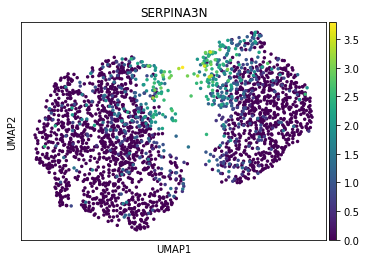

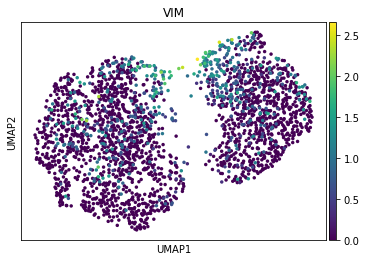

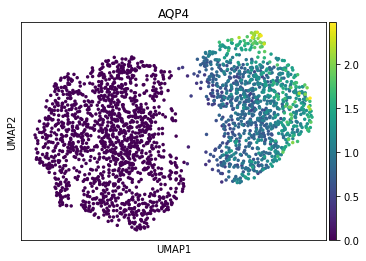

In [361]:
# Gene
sc.pl.umap(sdata, color='predicted_cell_type_label')
sc.pl.umap(sdata, color='APOE')
sc.pl.umap(sdata, color='C4B')
sc.pl.umap(sdata, color='SERPINA3N')
sc.pl.umap(sdata, color='VIM')
sc.pl.umap(sdata, color='AQP4')

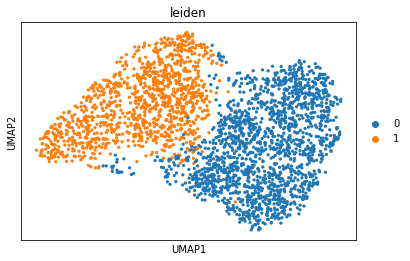

CPU times: user 245 ms, sys: 11.3 ms, total: 257 ms
Wall time: 261 ms


In [84]:
%%time
# Run leiden cluster
cluster_resolution = .1
sc.tl.leiden(sdata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(sdata, color='leiden')

# Save log
with open(f'./figures/log_{sub_id}.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}""")

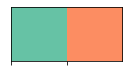

In [85]:
# OR use test colormap 
number_of_colors = sdata.obs['leiden'].unique().shape[0]
cluster_pl = sns.color_palette('Set2', number_of_colors)
sns.palplot(cluster_pl)
cluster_cmap = ListedColormap(cluster_pl)

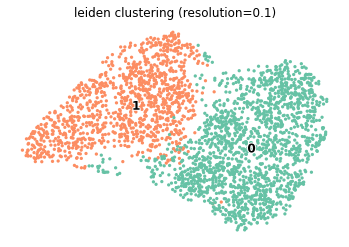

In [86]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl)

In [87]:
# Get markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')
# sc.tl.filter_rank_genes_groups(sdata, min_fold_change=1)

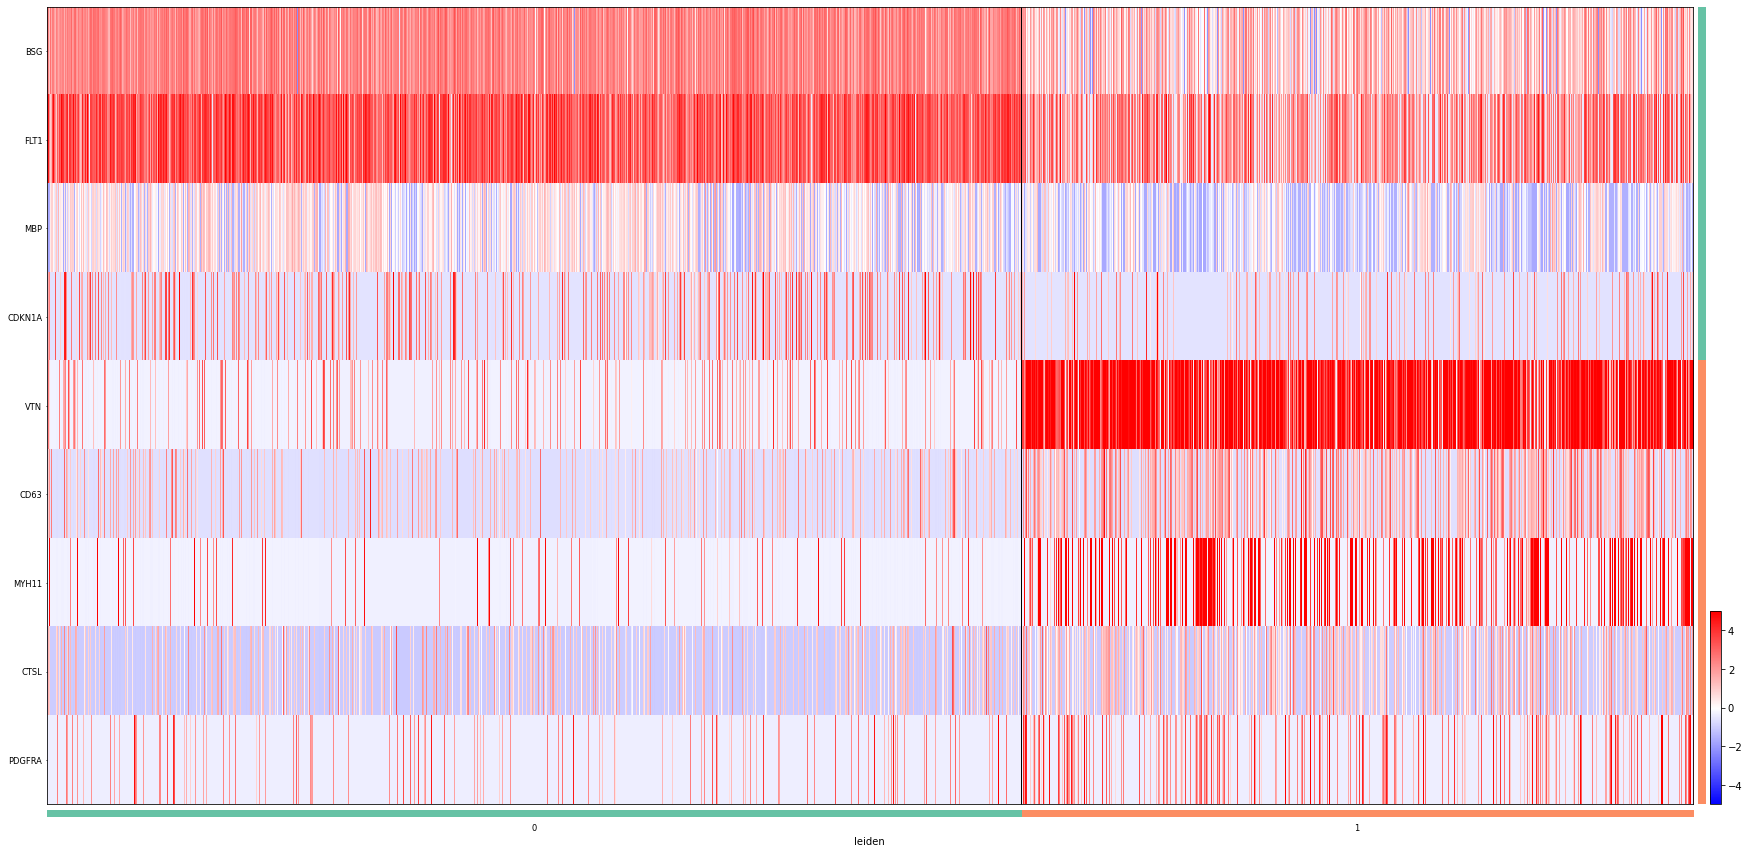

In [88]:
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save=False)

In [253]:
# Pick markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# # print(markers)
# plt.figure(figsize=(30,15))
# su.plot_heatmap_with_labels(sdata, markers, 'leiden', cmap=cluster_cmap, show_axis=True, font_size=10)

0 ['MBP', 'CLDN11', 'APOE', 'CACNG4', 'PLP1']
1 ['CD9', 'SLC17A7', 'GPM6A', 'CALM1', 'BRINP1']
2 ['KLK6', 'SERPINA3N', 'TMSB4X', 'C4B', 'CTSS']


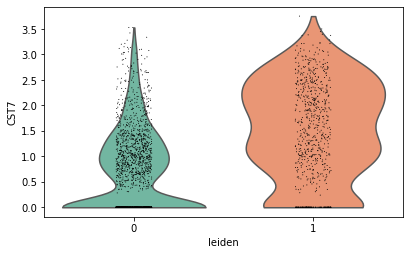

In [74]:
sc.pl.violin(sdata, 'CST7', groupby='leiden')

In [89]:
# Load data and store the information to uns
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'leiden'].astype(int).values

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [74]:

# cluster_pl = sns.color_palette('Set1', 2)
# sns.palplot(cluster_pl)
# cluster_cmap = ListedColormap(cluster_pl)

In [90]:
# Check current spatial cell type 
for i, sample in enumerate(sorted(sdata.obs['sample'].unique())):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [92]:
# Assign Endo / SMC back to top-level

adata.obs['top_level'] = adata.obs['top_level'].astype(object)

current_index = sdata.obs.loc[sdata.obs['leiden'] == '0', :].index
adata.obs.loc[current_index, 'top_level'] = 'Endo'

current_index = sdata.obs.loc[sdata.obs['leiden'] == '1', :].index
adata.obs.loc[current_index, 'top_level'] = 'SMC'

current_top_level_order = ['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'Mix']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'] = adata.obs['top_level'].cat.reorder_categories(current_top_level_order)



In [100]:
adata.uns['top_level_order_64'] = current_top_level_order
adata.uns['top_hex_dict_64'] = {'Astro': '#29e322',
                                 'CA1': '#b8adff',
                                 'CA2': '#f2402c',
                                 'CA3': '#5bb0eb',
                                 'DG': '#698270',
                                 'Endo': '#f9cfff',
                                 'Ex': '#5fd9c3',
                                 'Inhi': '#ebeb00',
                                 'Mix': '#969696',
                                 'Micro': '#fcb900',
                                 'OPC': '#8600d4',
                                 'Oligo': '#c800cc',
                                 'SMC': '#ab4b66'}

adata.uns['top_rgb_dict_64'] = {'Astro': np.array([0.16078431, 0.89019608, 0.13333333]),
                                 'CA1': np.array([0.72156863, 0.67843137, 1.        ]),
                                 'CA2': np.array([0.94901961, 0.25098039, 0.17254902]),
                                 'CA3': np.array([0.35686275, 0.69019608, 0.92156863]),
                                 'DG': np.array([0.41176471, 0.50980392, 0.43921569]),
                                 'Endo': np.array([0.97647059, 0.81176471, 1.        ]),
                                 'Ex': np.array([0.37254902, 0.85098039, 0.76470588]),
                                 'Inhi': np.array([0.92156863, 0.92156863, 0.        ]),
                                 'Mix': np.array([0.5882352941176471, 0.5882352941176471, 0.5882352941176471]),
                                 'Micro': np.array([0.98823529, 0.7254902 , 0.        ]),
                                 'OPC': np.array([0.5254902 , 0.        , 0.83137255]),
                                 'Oligo': np.array([0.78431373, 0.        , 0.8       ]),
                                 'SMC': np.array([0.67058824, 0.29411765, 0.4       ])}

In [76]:
# Assign CA2 back to top-level

current_index = sdata.obs.loc[sdata.obs['leiden'] == '1', :].index
adata.obs['top_level'] = adata.obs['top_level'].astype(object)
adata.obs.loc[current_index, 'top_level'] = 'CA2'

current_top_level_order = ['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'Astro', 'Endo-SMC', 'Micro', 'Oligo', 'OPC', 'Mix']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'] = adata.obs['top_level'].cat.reorder_categories(current_top_level_order)



In [65]:
# Assign CA2 back to top-level

current_index = sdata.obs.loc[sdata.obs['leiden'] == '1', :].index
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].astype(object)
adata.obs.loc[current_index, 'predicted_top_level'] = 'CA2'

current_top_level_order = [c for c in adata.uns['top_level_order'] if c in adata.obs['predicted_top_level'].unique()]
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].astype('category')
adata.obs['predicted_top_level'] = adata.obs['predicted_top_level'].cat.reorder_categories(current_top_level_order)



In [101]:
adata.obs.to_csv('./output/2021-04-12-obs.csv')

In [105]:
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'] = None
    adata.uns[current_key]['coords'] = None

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [107]:
adata.uns['rank_genes_groups_filtered'] = None

In [108]:
adata.write_h5ad('./output/2021-04-12-starmap-mAD-64-genes-scaled.h5ad')

In [400]:
curr_gene = 'GFAP'
subset_type = 'Ex'
# subset_type = None

cmap = sns.color_palette('viridis', as_cmap=True)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    
#     if subset_type is not None:
#         current_index = adata.obs['top_level'] == subset_type
#         sdata = adata[current_index, :]
#     else:
#         sdata = adata

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
        
    su.plot_poly_cells_expr_by_sample(sdata, sample, curr_gene, cmap, use_raw=False,
                                      figscale=30, width=10, height=10,
                                      show_plaque=True, show_tau=True, show_tau_cells=False,
                                      show=False, save=f'{curr_gene}_z')

AD_mouse9721
-1.8062496 2.4637156
AD_mouse9781
-1.8062496 2.4637156
AD_mouse9919
-1.8062496 2.4637156
AD_mouse9930
-1.8062496 2.4637156


In [480]:
genes = ['PLP1', 'MBP', 'CLDN11', 'KLK6', 'C4B', 'CDKN1A']

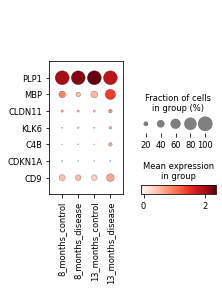

In [481]:
final_genes = genes + ['CD9']
sc.pl.dotplot(sdata, final_genes, groupby='tag', use_raw=False, swap_axes=True)

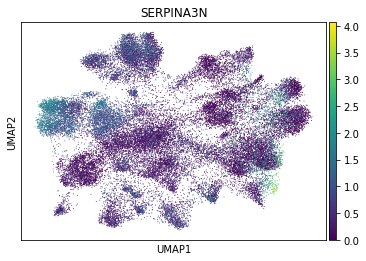

In [365]:
sc.pl.umap(adata, color='SERPINA3N')

In [404]:
adata[:, 'GFAP'].X.flatten()

ArrayView([ 1.01228295, -1.48313029,  2.55184173, ...,  2.22018387,
            0.05283902,  0.67374307])

<AxesSubplot:xlabel='gfap'>

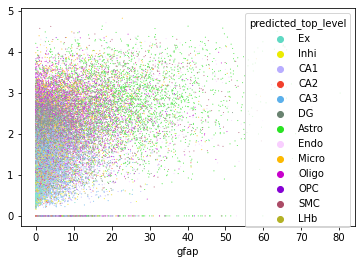

In [421]:
sns.scatterplot(adata.obs['gfap'], adata.raw[:, 'GFAP'].X.flatten(), s=1, hue=adata.obs['predicted_top_level'], palette=cluster_pl)

### assign cell type label

In [870]:
# Change cluster label to cell type label
transfer_dict = {}
# cell_type_list = ['CA3', 'CA2']
# cell_type_list = ['Inhi_Pvalb', 'Inhi_Sst', 'Inhi_Cnr1', 'Inhi_Lamp5']
# cell_type_list = ['L4/RSC_A', 'L6', 'L2/3', 'L4/RSC_B']
# cell_type_list = ['Endo', 'Endo_Cldn5+', 'Endo_Esam+']
# cell_type_list = ['Astro', 'Astro_Aqp4/Gfap', 'Astro_Gpr37l1/Cst3', 'Astro_Id4/Cst3']
# cell_type_list = ['Micro', 'Micro_Cst7/Ctsb', 'Micro_Gpr34']
# cell_type_list = ['Oligo', 'Oligo_Neat1/Enpp2', 'Oligo_Cldn11', 'Oligo_Ntsr1', 'Oligo_Tmem88b',
#                  'Oligo_Klk6', 'Oligo_Itga9']
# cell_type_list = ['Peri_A', 'Peri_B', 'SMC', 'VLMC_A', 'VLMC_B']
cell_type_list = ['OPC', 'OPC_Gpr17']

for i in sorted(sdata.obs['leiden'].unique()):
    transfer_dict[i] = cell_type_list[int(i)]

In [871]:
# Assign cell type to sdata
sdata.obs['cell_type'] = sdata.obs['leiden'].values
sdata.obs = sdata.obs.replace({'cell_type': transfer_dict})

# Sort category
cell_type_list = sorted(cell_type_list)
sdata.obs['cell_type'] = sdata.obs['cell_type'].astype('category')
sdata.obs['cell_type'].cat.reorder_categories(cell_type_list, inplace=True)

In [872]:
# # Get random cluster colors
# number_of_colors = sdata.obs['leiden'].unique().shape[0]
# color_points = intervals(number_of_colors, .0, .3)
# cluster_color = []
# for i in range(number_of_colors):
#     cluster_color.append(colorsys.hsv_to_rgb(color_points[i], .7, 1))

    
# cluster_pl = sns.color_palette(cluster_color)
# sns.palplot(cluster_pl)
# cluster_cmap = ListedColormap(cluster_color)

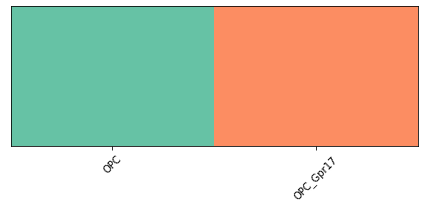

In [873]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(cell_type_list)), cell_type_list, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

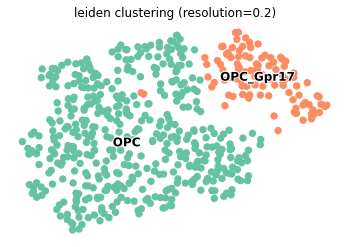

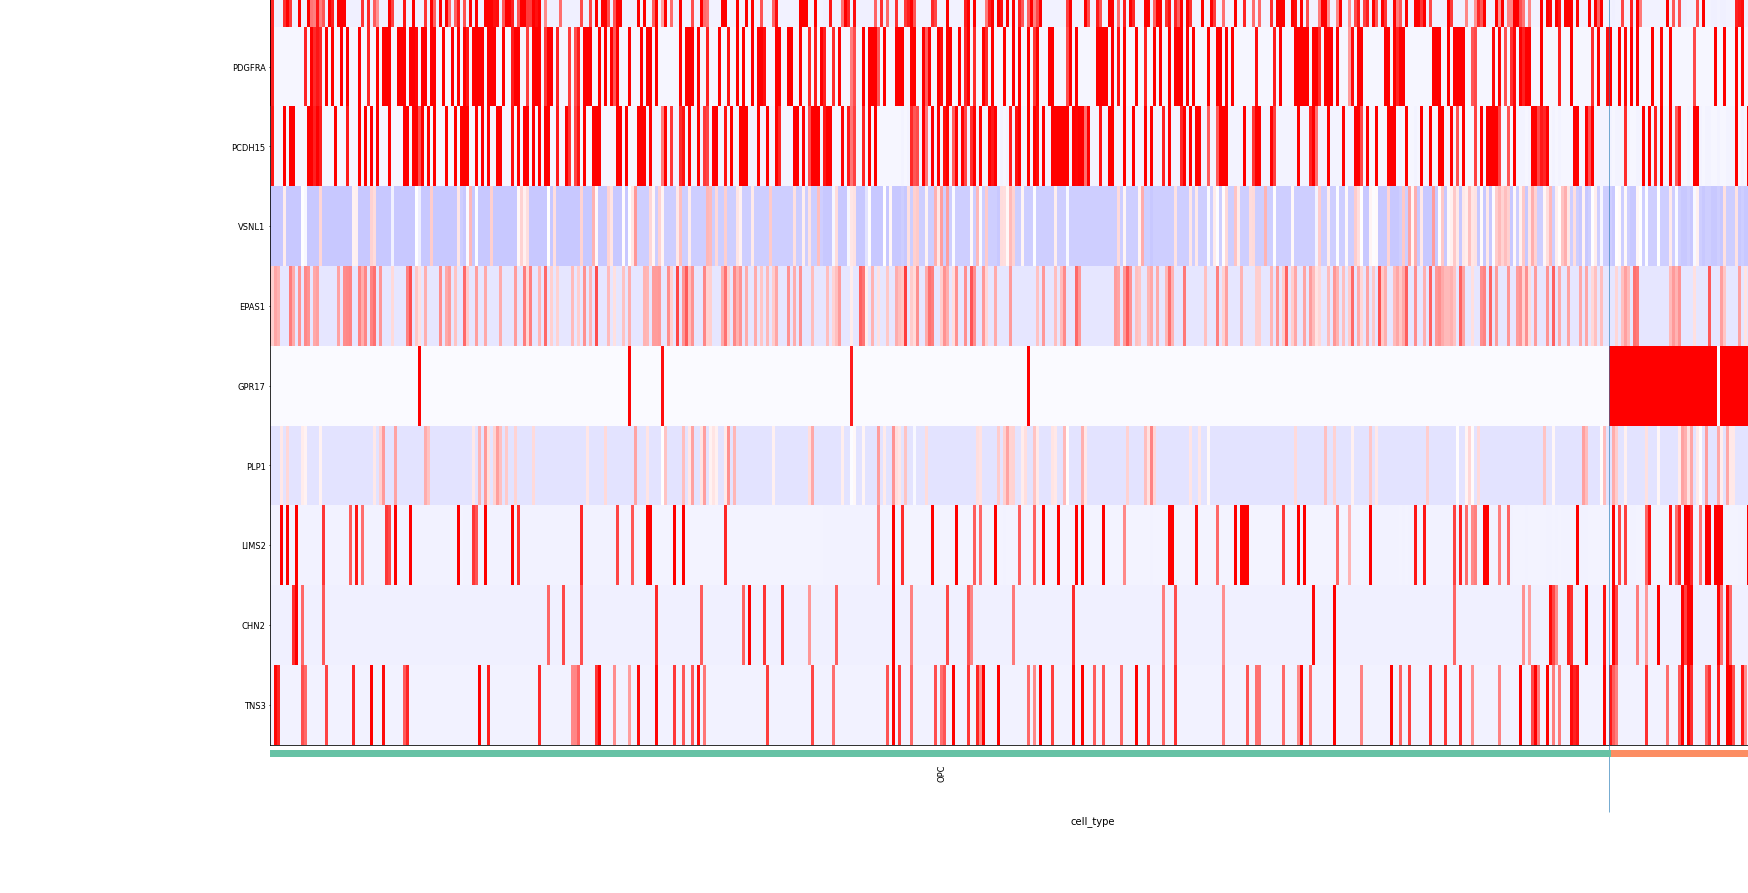

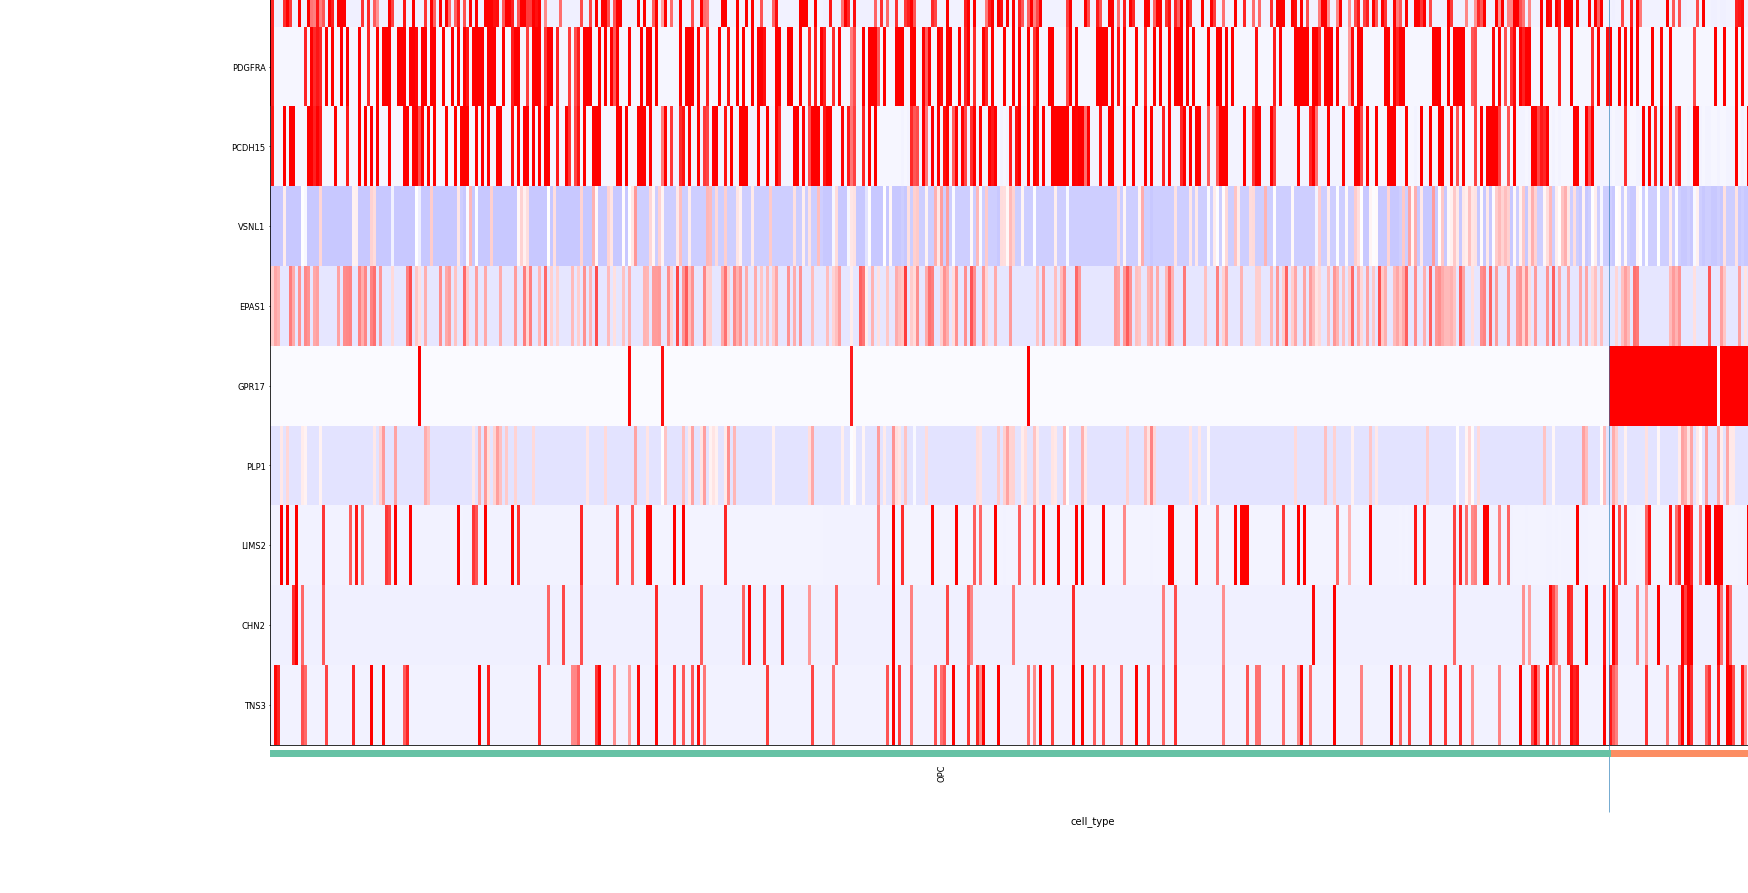

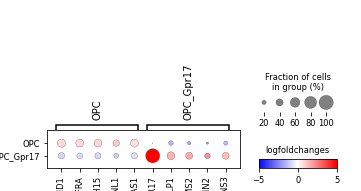

['CCND1', 'PDGFRA', 'PCDH15', 'VSNL1', 'EPAS1']
['GPR17', 'PLP1', 'LIMS2', 'CHN2', 'TNS3']


In [874]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl, save=True)

sc.tl.rank_genes_groups(sdata, 'cell_type', method='wilcoxon')
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(sdata, groupby='cell_type', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=.5, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Pick markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

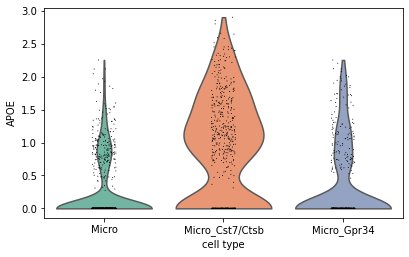

In [648]:
sc.pl.violin(sdata, 'APOE', groupby='cell_type', save='_Apoe')

In [875]:
# Check current spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=sub_id, show=False)

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


### add to complete obj

In [876]:
# Map to original obj
# adata.obs['cell_type'] = adata.obs['top_level'].astype(object)
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

array(['DG', 'Astro_Id4/Cst3', 'VLMC_A', 'Micro_Cst7/Ctsb', 'Endo',
       'Inhi_Pvalb', 'L4/RSC_A', 'Oligo', 'Astro', 'Oligo_Klk6',
       'Micro_Gpr34', 'Endo_Cldn5+', 'L4/RSC_B', 'L6', 'CA3',
       'Astro_Aqp4/Gfap', 'Oligo_Neat1/Enpp2', 'L2/3', 'Micro',
       'OPC_Gpr17', 'Peri_A', 'Inhi_Cnr1', 'Oligo_Ntsr1', 'Oligo_Itga9',
       'Peri_B', 'Endo_Esam+', 'Astro_Gpr37l1/Cst3', 'Oligo_Tmem88b',
       'Oligo_Cldn11', 'Inhi_Sst', 'OPC', 'CA2', 'CA1', 'Inhi_Lamp5',
       'SMC', 'LHb', 'VLMC_B'], dtype=object)

In [877]:
# Update color and cell type order 
complete_cluster_pl = complete_cluster_pl + cluster_pl
complete_cell_type_order = complete_cell_type_order + cell_type_list

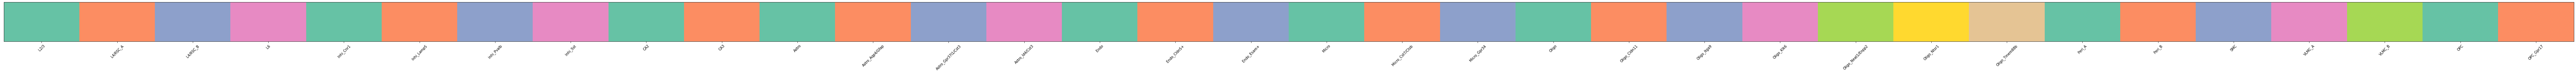

In [878]:
# Check complete meta
sns.palplot(complete_cluster_pl, size=3)
plt.xticks(range(len(complete_cell_type_order)), complete_cell_type_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [879]:
adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [880]:
# backup
adata.write_h5ad('./output/2020-11-11-mAD-bk.h5ad')

... storing 'cell_type' as categorical


### Plot complete

In [ ]:
# Save complete 
adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [ ]:
# reorder category
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type'].cat.reorder_categories(complete_cell_type_order, inplace=True)
adata.obs['cell_type']

In [ ]:
# # Check color legend
# sns.palplot(complete_cluster_pl, size=3)
# plt.xticks(range(len(complete_cell_type_order)), complete_cell_type_order, size=10, rotation=45)
# plt.tight_layout()
# plt.savefig(f'./figures/color_legend_complete.png')
# plt.show()

In [ ]:
# # Save related images with label 
# # Plot UMAP 
# plt.figure(figsize=(10, 10))
# sc.pl.umap(adata, color='cell_type', legend_loc='on data',
#            legend_fontsize=8, legend_fontoutline=1, frameon=False, 
#            title='Cell type', palette=complete_cluster_pl, save=f'_complete_type')

# # Plot heatmap
# sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
# sc.pl.rank_genes_groups_heatmap(adata, groupby='cell_type', n_genes=10, min_logfoldchange=1, use_raw=False, swap_axes=True, 
#                                 vmin=-3, vmax=3, cmap='bwr', show_gene_labels=False,
#                                 dendrogram=False, figsize=(30, 15), save=f'_complete')

### Plot top-level with label

In [ ]:
# Change cluster label to cell type label
transfer_dict = {}
cell_type_list = ['Ex', 'Oligo', 'DG', 'CA1', 'Astro', 'Endo', 'CA3', 'Inhi', 'Micro', 'OPC']

for i in sorted(adata.obs['louvain'].unique()):
    transfer_dict[i] = cell_type_list[int(i)]
    
transfer_dict

In [ ]:
# Assign cell type to sdata
adata.obs['top_level'] = adata.obs['louvain'].values
adata.obs = adata.obs.replace({'top_level': transfer_dict})

# Sort category
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(cell_type_list, inplace=True)

In [ ]:
# Get random cluster colors
number_of_colors = adata.obs['louvain'].unique().shape[0]
color_points = intervals(number_of_colors, .9, .9)
cluster_color = []
for i in range(number_of_colors):
    cluster_color.append(colorsys.hsv_to_rgb(color_points[i], .7, 1))

    
cluster_pl = sns.color_palette(cluster_color)
sns.palplot(cluster_pl)
cluster_cmap = ListedColormap(cluster_color)

In [ ]:
# OR reference colormap
cluster_pl = sns.color_palette("husl", 10)
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

In [ ]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(cell_type_list)), cell_type_list, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

In [ ]:
# Save related images with label 
# Plot UMAP 
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=8, legend_fontoutline=1, frameon=False, 
           title='Top-level clustering', palette=cluster_pl, save=f'_top_type')

# Plot heatmap
sc.tl.rank_genes_groups(adata, 'top_level', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata, groupby='top_level', n_genes=10, min_logfoldchange=.1, use_raw=False, swap_axes=True, 
                                vmin=-3, vmax=3, cmap='bwr', show_gene_labels=False,
                                dendrogram=False, figsize=(30, 15), save=f'_top')

In [ ]:
# Pick markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    # print(curr_col)
    
# print(markers)
plt.figure(figsize=(30,15))
su.plot_heatmap_with_labels(adata, markers, 'louvain', cmap=cluster_cmap, use_labels=cell_type_list,
                            show_axis=True, font_size=10)
plt.savefig('./figures/heatmap_top_v2.pdf')

In [ ]:
# Check current spatial cell type 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = adata.obs['sample'] == sample
    # change to new color 
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'louvain'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save='top', show=False)

## Change 

#### Load

In [ ]:
adata = sc.read_h5ad('./output/2020-11-1-Starmap.h5ad')
adata

In [ ]:
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'louvain'].astype(int).values

#### Astro_Endo to Endo

In [ ]:
# change label
adata.obs.loc[adata.obs['cell_type'] == 'Astro_Endo', :]

adata.obs.loc[adata.obs['cell_type'] == 'Astro_Endo', 'louvain'] = '5'
adata.obs.loc[adata.obs['cell_type'] == 'Astro_Endo', 'top_level'] = 'Endo'

In [ ]:
adata

In [ ]:
# for i, v in enumerate(adata.uns['complete_cell_type_order']):
#     print(i, v)
    
adata.uns['complete_cell_type_order'] = adata.uns['complete_cell_type_order'].tolist()
adata.uns['complete_cluster_pl'] = adata.uns['complete_cluster_pl'].tolist()

complete_cell_type_order = adata.uns['complete_cell_type_order'][:20] + adata.uns['complete_cell_type_order'][30:]
complete_cluster_pl = adata.uns['complete_cluster_pl'][:20] + adata.uns['complete_cluster_pl'][30:]

adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [ ]:
# After redo cluster 4
# Map to original obj
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

In [ ]:
# Update color and cell type order 
complete_cluster_pl = complete_cluster_pl[:20] + cluster_pl + complete_cluster_pl[20:]
complete_cell_type_order = complete_cell_type_order[:20] + cell_type_list + complete_cell_type_order[20:]

In [ ]:
for i, v in enumerate(complete_cell_type_order):
    print(i, v)

In [ ]:
# After redo cluster 5 
# Map to original obj
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

In [ ]:
# Update color and cell type order 
complete_cluster_pl = complete_cluster_pl[:23] + cluster_pl + complete_cluster_pl[23:]
complete_cell_type_order = complete_cell_type_order[:23] + cell_type_list + complete_cell_type_order[23:]

adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

#### Other to Ex

In [ ]:
# change label
adata.obs.loc[adata.obs['cell_type'] == 'Other', :]

adata.obs.loc[adata.obs['cell_type'] == 'Other', 'louvain'] = '0'
adata.obs.loc[adata.obs['cell_type'] == 'Other', 'top_level'] = 'Ex'

In [ ]:

complete_cell_type_order = complete_cell_type_order[7:-1]
complete_cluster_pl = complete_cluster_pl[7:-1]

adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [ ]:
# After redo cluster 0
# Map to original obj
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

In [ ]:
# Update color and cell type order 
complete_cluster_pl = cluster_pl + complete_cluster_pl
complete_cell_type_order = cell_type_list + complete_cell_type_order

#### test

In [893]:
len(sorted(adata.obs['top_level'].cat.categories))

12

In [888]:
for i in sorted(adata.obs['cell_type'].cat.categories):
    print(i)

Astro
Astro_Aqp4/Gfap
Astro_Gpr37l1/Cst3
Astro_Id4/Cst3
CA1
CA2
CA3
DG
Endo
Endo_Cldn5+
Endo_Esam+
Inhi_Cnr1
Inhi_Lamp5
Inhi_Pvalb
Inhi_Sst
L2/3
L4/RSC_A
L4/RSC_B
L6
LHb
Micro
Micro_Cst7/Ctsb
Micro_Gpr34
OPC
OPC_Gpr17
Oligo
Oligo_Cldn11
Oligo_Itga9
Oligo_Klk6
Oligo_Neat1/Enpp2
Oligo_Ntsr1
Oligo_Tmem88b
Peri_A
Peri_B
SMC
VLMC_A
VLMC_B


In [894]:
complete_cell_type_order = ['L2/3', 'L4/RSC_A', 'L4/RSC_B', 'L6', 'LHb',
                           'Inhi_Cnr1', 'Inhi_Lamp5', 'Inhi_Pvalb', 'Inhi_Sst',
                           'CA1', 'CA2', 'CA3', 'DG', 
                            'Astro', 'Astro_Aqp4/Gfap', 'Astro_Gpr37l1/Cst3', 'Astro_Id4/Cst3',
                           'Endo', 'Endo_Cldn5+', 'Endo_Esam+',
                           'Micro', 'Micro_Gpr34', 'Micro_Cst7/Ctsb',
                           'Oligo', 'Oligo_Cldn11', 'Oligo_Itga9', 'Oligo_Klk6', 'Oligo_Neat1/Enpp2', 'Oligo_Ntsr1', 'Oligo_Tmem88b',
                           'SMC', 'Peri_A', 'Peri_B', 'VLMC_A', 'VLMC_B',
                            'OPC', 'OPC_Gpr17']

In [896]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(complete_cell_type_order)

In [897]:
adata.obs['cell_type']

2                     DG
8         Astro_Id4/Cst3
9                     DG
11                VLMC_A
13       Micro_Cst7/Ctsb
              ...       
37057                LHb
37059           L4/RSC_A
37060                LHb
37061          Inhi_Cnr1
37062              Oligo
Name: cell_type, Length: 33106, dtype: category
Categories (37, object): ['L2/3', 'L4/RSC_A', 'L4/RSC_B', 'L6', ..., 'VLMC_A', 'VLMC_B', 'OPC', 'OPC_Gpr17']

In [900]:
adata.layers['raw']

array([[-0.2503524 , -0.19377005, -0.1940607 , ..., -0.44259354,
        -0.17535174, -0.5285805 ],
       [-0.2503524 , -0.19377005, -0.1940607 , ..., -0.44259354,
        -0.17535174, -0.5285805 ],
       [-0.2503524 ,  4.270369  , -0.1940607 , ..., -0.44259354,
        -0.17535174,  1.4482211 ],
       ...,
       [-0.2503524 , -0.19377005, -0.1940607 , ...,  2.104412  ,
        -0.17535174, -0.5285805 ],
       [-0.2503524 , -0.19377005, -0.1940607 , ..., -0.44259354,
        -0.17535174, -0.5285805 ],
       [-0.2503524 , -0.19377005, -0.1940607 , ..., -0.44259354,
        -0.17535174, -0.5285805 ]], dtype=float32)

In [913]:
adata.raw.X.sum(axis=1)

162.00464

<AxesSubplot:ylabel='Density'>

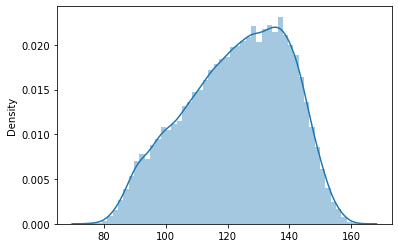

In [914]:
sns.distplot(adata.raw.X.sum(axis=1))

In [924]:
adata.uns['complete_cell_type_order'] = complete_cell_type_order

In [925]:
adata.write_h5ad('./output/2020-11-13-starmap_mAD.h5ad')

In [927]:
adata.obs.to_csv('./output/2020-11-13-obs.csv')

In [928]:
adata.var.to_csv('./output/2020-11-13-var.csv')

## Save

In [ ]:
adata.write_h5ad('./output/2020-11-1-Starmap-revised.h5ad')

In [ ]:
meta.loc[adata.obs.index, 'louvain'] = adata.obs['louvain']
meta.loc[adata.obs.index, 'top_level'] = adata.obs['top_level']
meta.loc[adata.obs.index, 'cell_type'] = adata.obs['cell_type']

meta.replace({np.nan: "NA"}, inplace=True)

In [ ]:
meta.loc[meta['cell_type'] == 'inhi_Lamp5', 'cell_type'] = 'Inhi_Lamp5'
meta.loc[meta['cell_type'] == 'inhi_Vip', 'cell_type'] = 'Inhi_Vip'
meta.loc[meta['cell_type'] == 'inhi_Cnr1', 'cell_type'] = 'Inhi_Cnr1'
meta.loc[meta['cell_type'] == 'inhi_Sst', 'cell_type'] = 'Inhi_Sst'
meta.loc[meta['cell_type'] == 'inhi_Reln', 'cell_type'] = 'Inhi_Reln'
meta.loc[meta['cell_type'] == 'inhi_Pvalb/Slc32a1+', 'cell_type'] = 'Inhi_Pvalb/Slc32a1+'
meta.loc[meta['cell_type'] == 'inhi_Pvalb/Slc32a1-', 'cell_type'] = 'Inhi_Pvalb/Slc32a1-'

In [ ]:
meta.to_csv('./output/2020-11-1-meta-revised.csv')

In [ ]:
adata = sc.read_h5ad('./output/2020-11-1-Starmap-revised.h5ad')

In [ ]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Lamp5', 'cell_type'] = 'Inhi_Lamp5'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Vip', 'cell_type'] = 'Inhi_Vip'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Cnr1', 'cell_type'] = 'Inhi_Cnr1'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Sst', 'cell_type'] = 'Inhi_Sst'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Reln', 'cell_type'] = 'Inhi_Reln'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Pvalb/Slc32a1+', 'cell_type'] = 'Inhi_Pvalb/Slc32a1+'
adata.obs.loc[adata.obs['cell_type'] == 'inhi_Pvalb/Slc32a1-', 'cell_type'] = 'Inhi_Pvalb/Slc32a1-'

In [ ]:
a = ['Inhi_Cnr1', 'Inhi_Lamp5', 'Inhi_Pvalb/Slc32a1+', 'Inhi_Pvalb/Slc32a1-', 'Inhi_Reln', 'Inhi_Sst', 'Inhi_Vip']

b = complete_cell_type_order[:32] + a + complete_cell_type_order[39:]
b

In [ ]:
sns.palplot(adata.uns['complete_cluster_pl'], size=3)
plt.xticks(range(len(adata.uns['complete_cell_type_order'])), adata.uns['complete_cell_type_order'], size=10, rotation=45)
plt.tight_layout()
plt.show()

## Gene trend comparison

In [116]:
new_obs = pd.read_csv('../2020-10-09-mAD-reads-assignment/output/2020-12-27-obs.csv', index_col=0)

# Set path
base_path = '../2020-10-09-mAD-reads-assignment/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

adata = adata[new_obs.index, :]
adata.obs = new_obs
adata

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 8], dtype='int64'), …


AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'

In [117]:
vdata = sc.read_h5ad('./output/2021-03-30-starmap-mAD-64-genes-raw.h5ad')
vdata.obs = pd.read_csv('./output/2021-04-12-obs.csv', index_col=0)
vdata

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 3], dtype='int64'), …


AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [118]:
# normalization 
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.normalize_total(vdata)
sc.pp.log1p(vdata)


In [119]:
# scaled

# sc.pp.scale(adata)

# sc.pp.scale(vdata)

In [120]:
gene_annotation = pd.read_csv('./genes_annotation.csv')
gene_annotation

adata.obs['tag'] = adata.obs['time'].astype(str) + '_' + adata.obs['group'].astype(str)
adata.obs['tag'] = adata.obs['tag'].astype('category')
adata.obs['tag'] = adata.obs['tag'].cat.reorder_categories(['8_months_control', '8_months_disease', 
                                                            '13_months_control', '13_months_disease'])

vdata.obs['tag'] = vdata.obs['time'].astype(str) + '_' + vdata.obs['group'].astype(str)
vdata.obs['tag'] = vdata.obs['tag'].astype('category')
vdata.obs['tag'] = vdata.obs['tag'].cat.reorder_categories(['8_months_control', '8_months_disease', 
                                                            '13_months_control', '13_months_disease'])


In [130]:
adata.obs.index = adata.obs.index.astype(str)
vdata.obs.index = vdata.obs.index.astype(str)

In [151]:
# Subset
sub_id = ['Ex', 'CA1', 'CA2', 'CA3']

curr_cells = adata.obs['top_level'].isin(sub_id)
sdata_2766 = adata[curr_cells, :]
sdata_2766

View of AnnData object with n_obs × n_vars = 13755 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label', 'tag'
    uns: 'log1p'

In [152]:
# Subset

# sub_obs = vdata.obs.loc[vdata.obs['predicted_top_level'] == sub_id, :]
# median_score = np.mean(sub_obs['predicted_top_level_score'])

# curr_cells = (vdata.obs['predicted_top_level'] == sub_id) & (vdata.obs['predicted_top_level_score'] > median_score)
curr_cells = vdata.obs['top_level'].isin(sub_id)
sdata_64 = vdata[curr_cells, :]
sdata_64

View of AnnData object with n_obs × n_vars = 13689 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level', 'tag'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'log1p'

In [145]:
genes = gene_annotation.loc[gene_annotation['top_level'] == sub_id, 'Gene'].to_list()

final_genes = genes # + ['CD9']

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'time' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'top_level' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_label' as categorical


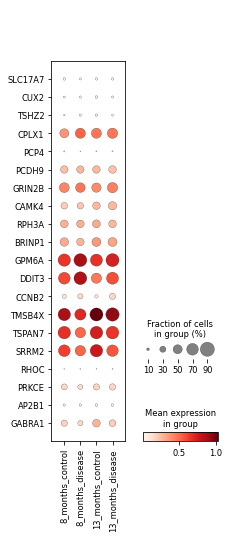

In [153]:
sc.pl.dotplot(sdata_2766, final_genes, groupby='tag', swap_axes=True)

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'time' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_top_level' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'top_level' as categorical


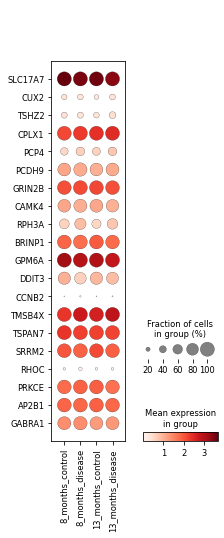

In [154]:
sc.pl.dotplot(sdata_64, final_genes, groupby='tag', swap_axes=True)

In [137]:
sdata_64[:, 'CST7'].X.mean()

ArrayView(1.0014827, dtype=float32)

In [149]:
gene_index = gene_annotation['top_level'].isin(['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 
                                  'All excitatory & Inhi', 'All excitatory', 'Tau positive neuron'])

gene_index = gene_annotation['top_level'].isin(['Ex', 'CA1', 'CA2', 'CA3', 'All excitatory & Inhi', 'All excitatory', 'Tau positive neuron'])


genes = gene_annotation.loc[gene_index, 'Gene'].to_list()
final_genes = genes